In [19]:
import numpy as np
import tensorflow as tf

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from utils import cartesian_product

In [23]:
max_wavevector_component_harmonic = 7
num_quasiwavevector_components = 99

In [24]:
wavevector_component_harmonics = np.arange(-max_wavevector_component_harmonic, max_wavevector_component_harmonic + 1)
wavevector_harmonics = cartesian_product(*(wavevector_component_harmonics,)*2)

position_components = np.linspace(-1/2, 1/2, wavevector_component_harmonics.size) # [spacing]

def wavevector_harmonic_to_index(wavevector_harmonic):
    return tuple(np.array(wavevector_harmonic) + np.full(2, max_wavevector_component_harmonic))

wavevector_harmonics.shape

(225, 2)

In [25]:
quasiwavevector_components = np.linspace(-1, 1, num_quasiwavevector_components) # [wavenumber]
quasiwavevectors = cartesian_product(*(quasiwavevector_components,)*2)

zero_quasiwavevector_index = (quasiwavevector_components.size - 1) // 2
max_quasiwavevector_index = -1

quasiwavevectors.shape

(9801, 2)

In [26]:
def compute_potential(square_depth, stripe_depth, superlattice_phase):
    intensity = np.zeros((wavevector_component_harmonics.size,)*2, dtype=complex)

    intensity[wavevector_harmonic_to_index((0, 0))]       = (1/4)*square_depth + (1/2)*stripe_depth
    for harmonic in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        intensity[wavevector_harmonic_to_index(harmonic)] = (1/8)*square_depth
    for harmonic in ((-1, 1), (1, -1)):
        intensity[wavevector_harmonic_to_index(harmonic)] = (1/16)*square_depth
    intensity[wavevector_harmonic_to_index((-1, -1))]     = (1/16)*square_depth + (1/4)*stripe_depth * np.exp( 1j * superlattice_phase)
    intensity[wavevector_harmonic_to_index(( 1,  1))]     = (1/16)*square_depth + (1/4)*stripe_depth * np.exp(-1j * superlattice_phase)

    return -intensity

In [27]:
def compute_tunneling_strengths(energies):
    return np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(energies[:, :, 0])))) / quasiwavevector_components.size**2

In [28]:
def compute_neighbor_tunneling_strengths(tunneling_strengths, radius=1):
    index_min = quasiwavevector_components.size // 2 - radius
    index_max = quasiwavevector_components.size // 2 + radius
    return tunneling_strengths[index_min:index_max+1, index_min:index_max+1]

In [29]:
effective_wavevectors = quasiwavevectors[:, np.newaxis, :] + 2*wavevector_harmonics
kinetic_energies = np.einsum('ijk, ijk -> ij', effective_wavevectors, effective_wavevectors).reshape(quasiwavevector_components.size, quasiwavevector_components.size, wavevector_harmonics.shape[0])

In [30]:
wavevector_change = wavevector_harmonics[:, np.newaxis] - wavevector_harmonics

In [31]:
RECOIL_ENERGY_752 = 1032 # Hz
RECOIL_ENERGY_532 = 2062 # Hz

# Square

In [32]:
potential = compute_potential(10, 0, 0)

In [33]:
transition_energies = tf.cast(tf.linalg.diag(kinetic_energies), dtype=tf.complex128) + np.array([ [ potential[tuple(np.clip(wavevector_harmonic_to_index(y), 0, 2))] for y in x ] for x in wavevector_change ])[np.newaxis, np.newaxis, :]
transition_energies.shape

TensorShape([99, 99, 225, 225])

In [21]:
np.array([ [ potential[tuple(np.clip(wavevector_harmonic_to_index(y), 0, 2))] for y in x ] for x in wavevector_change ])

array([[-2.5  -0.j, -1.25 -0.j, -1.25 -0.j, -1.25 -0.j, -0.625-0.j,
        -0.625-0.j, -1.25 -0.j, -0.625-0.j, -0.625-0.j],
       [-1.25 -0.j, -2.5  -0.j, -1.25 -0.j, -0.625-0.j, -1.25 -0.j,
        -0.625-0.j, -0.625-0.j, -1.25 -0.j, -0.625-0.j],
       [-1.25 -0.j, -1.25 -0.j, -2.5  -0.j, -0.625-0.j, -0.625-0.j,
        -1.25 -0.j, -0.625-0.j, -0.625-0.j, -1.25 -0.j],
       [-1.25 -0.j, -0.625-0.j, -0.625-0.j, -2.5  -0.j, -1.25 -0.j,
        -1.25 -0.j, -1.25 -0.j, -0.625-0.j, -0.625-0.j],
       [-0.625-0.j, -1.25 -0.j, -0.625-0.j, -1.25 -0.j, -2.5  -0.j,
        -1.25 -0.j, -0.625-0.j, -1.25 -0.j, -0.625-0.j],
       [-0.625-0.j, -0.625-0.j, -1.25 -0.j, -1.25 -0.j, -1.25 -0.j,
        -2.5  -0.j, -0.625-0.j, -0.625-0.j, -1.25 -0.j],
       [-1.25 -0.j, -0.625-0.j, -0.625-0.j, -1.25 -0.j, -0.625-0.j,
        -0.625-0.j, -2.5  -0.j, -1.25 -0.j, -1.25 -0.j],
       [-0.625-0.j, -1.25 -0.j, -0.625-0.j, -0.625-0.j, -1.25 -0.j,
        -0.625-0.j, -1.25 -0.j, -2.5  -0.j, -1.25 -0.j],


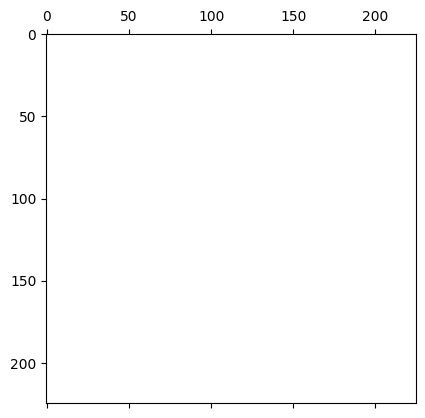

In [35]:
plt.spy(np.array([ [ potential[tuple(np.clip(wavevector_harmonic_to_index(y), 0, 2))] for y in x ] for x in wavevector_change ]))

In [11]:
energies = tf.math.real(tf.linalg.eigvalsh(transition_energies))

In [12]:
figure = go.Figure(data=[go.Surface(x=quasiwavevector_components, 
                                    y=quasiwavevector_components, 
                                    z=energies[:, :, 0])])
figure.update_layout(autosize=False, width=750, height=750)
figure.show()

In [17]:
tunneling_strengths = compute_tunneling_strengths(energies)
neighbor_tunneling_strengths = compute_neighbor_tunneling_strengths(tunneling_strengths, radius=2)
px.imshow(neighbor_tunneling_strengths * RECOIL_ENERGY_752, zmax=32.51314)

# Triangle

In [36]:
potential = compute_potential(4, 8 * RECOIL_ENERGY_532/RECOIL_ENERGY_752, 0)

In [37]:
transition_energies = tf.cast(tf.linalg.diag(kinetic_energies), dtype=tf.complex128) + np.array([ [ potential[tuple(np.clip(wavevector_harmonic_to_index(y), 0, 14))] for y in x ] for x in wavevector_change ])[np.newaxis, np.newaxis, :]
transition_energies.shape

TensorShape([99, 99, 225, 225])

In [38]:
energies = tf.math.real(tf.linalg.eigvalsh(transition_energies))

In [39]:
figure = go.Figure(data=[go.Surface(x=quasiwavevector_components, 
                                    y=quasiwavevector_components, 
                                    z=energies[:, :, 0])])
figure.update_layout(autosize=False, width=750, height=750)
figure.show()

In [40]:
tunneling_strengths = compute_tunneling_strengths(energies)
neighbor_tunneling_strengths = compute_neighbor_tunneling_strengths(tunneling_strengths, radius=2)
print(f"Horizontal/Vertical Tunneling: {neighbor_tunneling_strengths[2][1] * RECOIL_ENERGY_752:.4f}, Diagonal Tunneling: {neighbor_tunneling_strengths[3][1] * RECOIL_ENERGY_752:.4f}")
px.imshow(neighbor_tunneling_strengths * RECOIL_ENERGY_752, zmax=neighbor_tunneling_strengths[3][1] * RECOIL_ENERGY_752)

Horizontal/Vertical Tunneling: 15.3687, Diagonal Tunneling: 15.8377
